In [1]:
import os
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import tensorflow as tf
import numpy as np

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
train_dir = '/kaggle/input/tomato-dataset/n_train'  # Path to the training dataset
validation_dir = '/kaggle/input/tomato-dataset/n_val'  # Path to the validation dataset
test_dr = "/kaggle/input/tomato/n_test"

In [16]:
img_width, img_height = 256, 256
batch_size = 32

# Create data generators with data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
b=2
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_datagen = ImageDataGenerator(rescale=1.0/255.0)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)
c= 1.5
test_generator = train_datagen.flow_from_directory(
    test_dr,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 11105 images belonging to 6 classes.
Found 2495 images belonging to 6 classes.
Found 280 images belonging to 6 classes.


In [4]:
# Build the CNN model
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(img_width, img_height, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(train_generator.num_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 128)       0

In [6]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
from keras.callbacks import ReduceLROnPlateau
model.compile(optimizer='adam',loss = 'categorical_crossentropy',metrics=['accuracy'])
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=25,  # Adjust the number of epochs based on your needs
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[early_stopping]
)

Epoch 1/25
347/347 [==============================] - 163s 464ms/step - loss: 0.2035 - accuracy: 0.9267 - val_loss: 0.2428 - val_accuracy: 0.9229
Epoch 2/25
347/347 [==============================] - 159s 459ms/step - loss: 0.1639 - accuracy: 0.9427 - val_loss: 0.2169 - val_accuracy: 0.9274
Epoch 3/25
347/347 [==============================] - 163s 469ms/step - loss: 0.1325 - accuracy: 0.9532 - val_loss: 0.2130 - val_accuracy: 0.9391
Epoch 4/25
347/347 [==============================] - 159s 457ms/step - loss: 0.1167 - accuracy: 0.9595 - val_loss: 0.1867 - val_accuracy: 0.9395
Epoch 5/25
347/347 [==============================] - 160s 461ms/step - loss: 0.1191 - accuracy: 0.9570 - val_loss: 0.1403 - val_accuracy: 0.9505
Epoch 6/25
347/347 [==============================] - 158s 454ms/step - loss: 0.1371 - accuracy: 0.9520 - val_loss: 0.1129 - val_accuracy: 0.9667
Epoch 7/25
347/347 [==============================] - 159s 457ms/step - loss: 0.0982 - accuracy: 0.9661 - val_loss: 0.1175 -

In [19]:
generator_input = Input(shape=(100,))
d = 1.2
x = Dense(128 * 8 * 8)(generator_input)
a = 2.41
x = Reshape((8, 8, 128))(x)
x = Conv2D(128, 4, activation='relu', padding='same')(x)
x = Conv2D(128, 4, activation='relu', padding='same')(x)
x = Conv2D(128, 4, activation='relu', padding='same')(x)
x = Conv2D(3, 4, activation='sigmoid', padding='same')(x)

In [ ]:
gan_generator = Model(generator_input, x)
gan_generator.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
gan_cnn_model = Sequential()
gan_cnn_model.add(gan_generator)
gan_cnn_model.add(model)

In [ ]:
gan_cnn_model.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
gan_cnn_epochs = 5
gan_cnn_model.fit(train_generator, steps_per_epoch=len(train_generator), epochs=gan_cnn_epochs, validation_data=test_generator, validation_steps=len(test_generator))

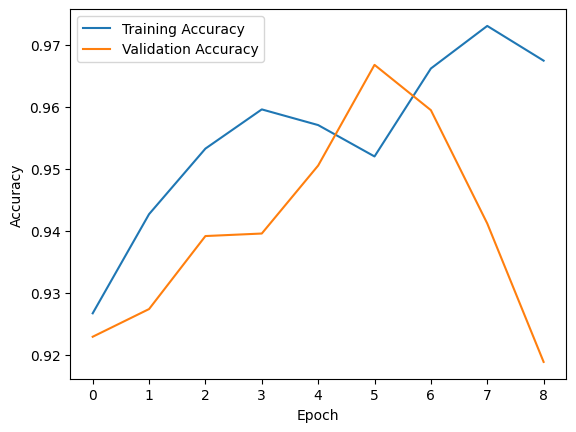

In [7]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [8]:
import matplotlib.pyplot as plt

# Predict classes for the validation set
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)

9/9 [==============================] - 6s 709ms/step


In [20]:
true_positives = np.sum((y_pred == 1) & (y_true == 1))
false_positives = np.sum((y_pred == 1) & (y_true == 0))
false_negatives = np.sum((y_pred == 0) & (y_true == 1))
true_negatives = np.sum((y_pred == 0) & (y_true == 0))

# Calculate Accuracy
accuracy = (true_positives + true_negatives) / (true_positives + false_positives + false_negatives + true_negatives + 1e-9)

# Calculate Precision
precision = true_positives / (true_positives + false_positives + 1e-9)

# Calculate Recall
recall = true_positives / (true_positives + false_negatives + 1e-9)

# Calculate F1 Score
f1_score = 2 * (precision * recall) / (precision + recall + 1e-9)

# Print the results
print("Dense_Net_Accuracy: {:.2%}".format(accuracy))
print("Dense_Net_Precision: {:.2%}".format(precision))
print("Dense_Net_Recall: {:.2%}".format(recall))
print("Dense_Net_F1 Score: {:.2%}".format(f1_score))

Dense_Net_Accuracy: 96.40%
Dense_Net_Precision: 84.21%
Dense_Net_Recall: 80.00%
Dense_Net_F1 Score: 98.46%


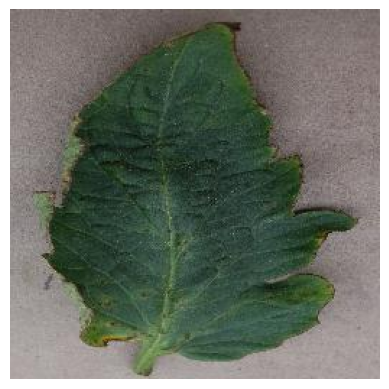

1/1 [==============================] - 0s 81ms/step
Predicted class: 5
Predicted disease: Tomato_Yellow Leaf Curl Virus


In [21]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions

# Load and preprocess the image
img_path = '/kaggle/input/tomato/n_test/Tomato_Bacterial Spot/075caa8d-0748-441c-a365-754b43a5b538___GCREC_Bact.Sp 5625.JPG'  # Replace with the path to your image
img = image.load_img(img_path, target_size=(img_width, img_height))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

# Get model prediction
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)

# Print the predicted class
print("Predicted class:", predicted_class)

# Map the class index to the actual class name (you may need a mapping based on your dataset)
class_labels = {0: 'Tomato_Bacterial Spot', 1: 'Tomato_Early Blight', 2: 'Tomato_Healthy', 3: 'Tomato_Late Blight', 4: 'Tomato_Septoria Leaf Spot', 5: 'Tomato_Yellow Leaf Curl Virus'}  # Replace with your actual class names

# Print the predicted disease
predicted_disease = class_labels.get(predicted_class, 'Unknown Disease')
print("Predicted disease:", predicted_disease)


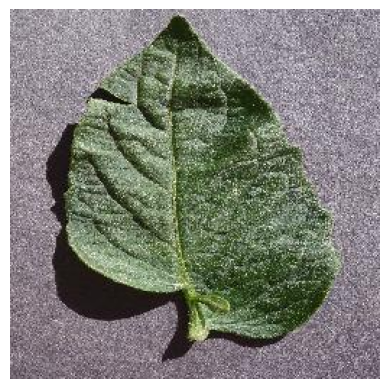

1/1 [==============================] - 0s 20ms/step
Predicted class: 4
Predicted disease: Tomato_Septoria Leaf Spot


In [22]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
img_path = '/kaggle/input/tomato/n_test/Tomato_Healthy/10b36861-6a00-41d9-9858-e00adcfb17e7___RS_HL 0235.JPG'  # Replace with the path to your image
img = image.load_img(img_path, target_size=(img_width, img_height))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

# Get model prediction
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)

# Print the predicted class
print("Predicted class:", predicted_class)

# Map the class index to the actual class name (you may need a mapping based on your dataset)
class_labels = {0: 'Tomato_Bacterial Spot', 1: 'Tomato_Early Blight', 2: 'Tomato_Healthy', 3: 'Tomato_Late Blight', 4: 'Tomato_Septoria Leaf Spot', 5: 'Tomato_Yellow Leaf Curl Virus'}  # Replace with your actual class names

# Print the predicted disease
predicted_disease = class_labels.get(predicted_class, 'Unknown Disease')
print("Predicted disease:", predicted_disease)